# Анализ результатов A/B тестирования

#### Описание данных:  

1. Датасет `ab_project_marketing_events.csv` - календарь маркетинговых событий на 2020 год:
- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.


2. Датасет `final_ab_new_users.csv` - все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года:
- `user_id` — уникальный идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион, к которому относится пользователь;
- `device` — устройство, с которого происходила регистрация.


3. Датасет `final_ab_events.csv` -  все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:
- `user_id` — уникальный идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — наименование типа события;
- `details` — дополнительные данные о событии. Например, в этом поле хранится стоимость покупки (USD) для события «покупка» (`purchase`).


4. Датасет `final_ab_participants.csv` - таблица участников тестов:
- `user_id` — уникальный идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа, в которой находился пользователь в рамках теста.

#### Цель исследования - 
по результатам A/B теста "recommender_system_test" принять решение о внедрении улучшенной рекомендательной системы.

План работы:

[- Шаг 1. Обзор данных;](#step1)  
[- Шаг 2. Предобработка данных;](#step2)  
[- Шаг 3. Исследовательский анализ данных:](#step3)  
  - анализ конверсии воронки на разных этапах;
  - определить обладают ли выборки одинаковыми распределениями количества событий на пользователя;
  - выявить присутствие в выборках одних и тех же пользователей;
  - проанализировать как число событий распределено по дням.

[- Шаг 4. Оценка результатов А/В тестирования:](#step4)  
  - анализ результатов А/B тестирования;
  - проверка статистической разницы долей z-критерием.

[- Шаг 5. Общие выводы.](#step5)  

In [1]:
import pandas as pd

In [2]:
import time
from datetime import date

In [3]:
import warnings
warnings.simplefilter("ignore")

In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np

In [6]:
import seaborn as sns

In [7]:
import ipywidgets as widgets
from ipywidgets import interact

In [8]:
from scipy import stats as st

In [9]:
import math as mth

### Шаг 1. Обзор данных.<a id="step1">

In [10]:
marketing_events = pd.read_csv('ab_project_marketing_events.csv')
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [11]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [12]:
new_users = pd.read_csv('final_ab_new_users.csv')
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [13]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [14]:
events = pd.read_csv('final_ab_events.csv')
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [15]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [16]:
participants = pd.read_csv('final_ab_participants.csv')
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [17]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


### Вывод.

df `marketing_events` состоит из 4 столбцов и 14 строк, пропущенных значений нет, необходимо привести столбцы с датой к типу datetime.  
df `new_users` состоит из 440317 строк и 4 столбцов, есть пропущенные значения в столбце `details`, для их восстановления недостаточно информации, стобец с датой нобходимо привести к типу datetime.   
df `participants` состоит из 18268 строк и 3 столбцов, пропущенных значений нет, типы данных корректны. 

### Шаг 2. Предобработка данных.<a id="step2">

Приведем все столбцы с датами к типу datetime

In [18]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])

Набор новых пользователей проходил в период 2020-12-07 - 2020-12-21, отфильтруем df new_users по заданному периоду

In [19]:
new_users['first_date'].describe()

count                   61733
unique                     17
top       2020-12-21 00:00:00
freq                     6290
first     2020-12-07 00:00:00
last      2020-12-23 00:00:00
Name: first_date, dtype: object

In [20]:
d3 = date(2020, 12, 21)
new_users = new_users.query('first_date <= @d3')

In [21]:
events['event_dt'].describe()

count                  440317
unique                 267268
top       2020-12-23 02:37:24
freq                       10
first     2020-12-07 00:00:33
last      2020-12-30 23:36:33
Name: event_dt, dtype: object

Проверим данные на наличие дубликатов

In [22]:
new_users.duplicated().sum()
events.duplicated().sum()
participants.duplicated().sum()

0

По заданию необходимо анализировать 14 дней активности пользователей с момента регистрации, оставим в df participants только тех пользователей, которые есть в df new_users. После мы определим в df events тех пользователей, кто участвовал в тесте (для пользователей, которые есть в таблице participants с пометкой названия теста recommender_system_test). События events зафиксированы за 14 дней, с 7-30 декабря 2020 г., то есть как и необходимо по условию задания.

In [23]:
participants = participants.merge(new_users, on='user_id')

Рассмотрим типы тестов и оставим данные только по необходимому для анализа тесту "recommender_system_test"

In [24]:
participants['ab_test'].unique()
participants = participants.loc[participants['ab_test'] == 'recommender_system_test']

Оставим в таблице только пользователей, участвующих в тесте

In [25]:
events = events.merge(participants, on='user_id')

In [26]:
new_users = new_users.merge(participants, on='user_id')

Период проведения теста 2020-12-07 - 2020-30-12, оставим маркетинговые события, попадающие в этот период

In [27]:
d1 = date(2020, 12, 7)
d2 = date(2020, 1, 4)
d2

datetime.date(2020, 1, 4)

In [28]:
marketing_events = marketing_events.query('start_dt >= @d1 or finish_dt <= @d2')
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


По плану в тесте должны были участвовать 6000 пользователей, но по результатам предобработки данных видно, что пользователей, которые выполнили хотя бы одно из отслеживаемых событий всего 3675

In [29]:
participants['user_id'].nunique()

6701

In [30]:
events['user_id'].nunique()

3675

In [31]:
new_users['user_id'].nunique()

6701

### Вывод

В данных были результаты другого A/B теста, мы их удалили. Таблица с маркетинговыми событиями содержала информацию по событиям периода, не входящего в период анализа, удалили неактуальные. Отфильтровали таблицы по заданным периодам исследования, исключив данные, выпадающие за нужный период. Отфильтровали таблицы по id пользователей, оставили только пользователей, принимающих участие в тесте "recommender_system_test".  
По плану в тесте должны были участвовать 6000 пользователей, но по результатам предобработки данных видно, что пользователей, которые выполнили хотя бы одно из отслеживаемых событий всего 3675.
События в тесте зафиксированы на 14 дней (по новым зарегистрированным пользователям) с 07 по 30 декабря 2020 года.

### Шаг 3. Исследовательский анализ данных.<a id="step3">

По ТЗ теста предполагается получить 15% новых пользователей из региона EU, проверим фактическое значение

In [32]:
events_user_unique = events.groupby('region').agg({'user_id':'nunique'}).reset_index()
count_EU = events_user_unique[events_user_unique['region']=="EU"]['user_id'].sum()/events_user_unique['user_id'].sum()
print('Доля пользователей из региона EU: {:.2%}'.format(count_EU))

Доля пользователей из региона EU: 94.72%


Посмотрим какие события есть в логах и как часто они встречаются

In [33]:
events.groupby(['group', 'event_name']).agg({'user_id':('count', 'nunique')})

user_id        
                     count nunique
group event_name                  
A     login           8566    2747
      product_cart    2558     824
      product_page    5525    1780
      purchase        2655     872
B     login           2624     928
      product_cart     689     255
      product_page    1405     523
      purchase         676     256

По данным таблицы видно, что пользователи распределились по группам теста не поровну, а количество событий purchase превышает количество событий 

Посмотрим присутствуют ли в выборках одних и те же пользователи

In [34]:
dupl = events.groupby('user_id').agg({'group':'nunique'}).reset_index()
dupl.loc[dupl.loc[:, 'group'] == '2']['user_id'].count()

0

В выборках по группам теста пользователи не дублируются

Построим распределение пользователей по стоимости совершенных покупок

(0, 110)

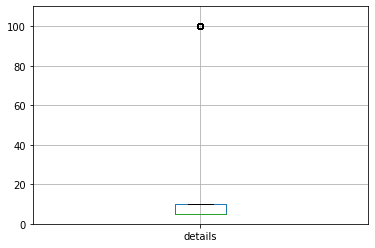

In [35]:
events.boxplot(column='details')
plt.ylim(0, 110)

Удалим покупки стоимость которых выше 10 у.е.

In [36]:
events = events.query('details <= 10 or details == "NaN"')

Посмотрим на распределение частоты встречаемости события login

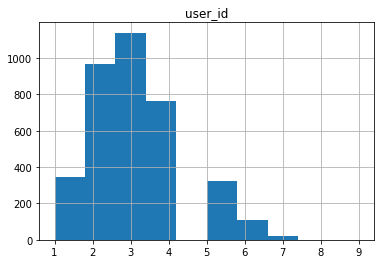

In [37]:
login = events[events['event_name'] == 'login']
login = login['user_id'].value_counts().reset_index()
login.hist();

In [38]:
np.percentile(login['user_id'], [93, 95, 97])

array([5., 5., 6.])

5% пользователей генерировало событие login 6 и более раз, удалим этих пользователей

In [39]:
#создадим список пользователей, совершавших событие login 6 и более раз
login = login[login['user_id'] >= 6]
login = login['index'].tolist()

In [40]:
events = events.query('user_id != @login')

Посмотрим на распределение частоты встречаемости события product_cart

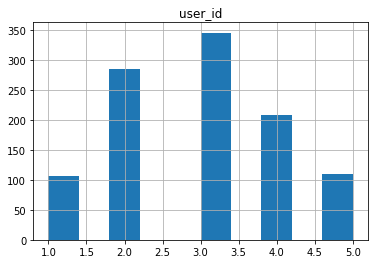

In [41]:
product_cart = events[events['event_name'] == 'product_cart']
product_cart = product_cart['user_id'].value_counts().reset_index()
product_cart.hist();

In [42]:
np.percentile(product_cart['user_id'], [93, 95, 97])

array([5., 5., 5.])

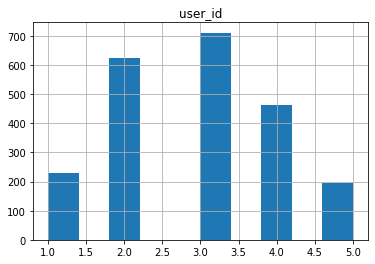

In [43]:
product_page = events[events['event_name'] == 'product_page']
product_page = product_page['user_id'].value_counts().reset_index()
product_page.hist();

In [44]:
np.percentile(product_page['user_id'], [93, 95, 97])

array([5., 5., 5.])

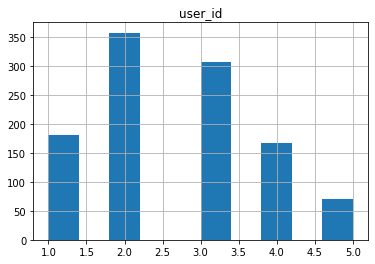

In [45]:
purchase = events[events['event_name'] == 'purchase']
purchase = purchase['user_id'].value_counts().reset_index()
purchase.hist();

In [46]:
np.percentile(purchase['user_id'], [93, 95, 97])

array([4., 5., 5.])

95% пользователей совершают кокупку менее 5 раз, удалим 5% пользователей, совершающих покупку чаще

In [47]:
#создадим список пользователей, совершавших событие login 6 и более раз
purchase = purchase[purchase['user_id'] >= 5]
purchase = purchase['index'].tolist()

In [48]:
events = events.query('user_id != @purchase')

Посмотрим как события распределены по дням

In [49]:
#создадм столбец с днем события
events['event_day'] = events['event_dt'].dt.day

In [50]:
@interact 
def event(name_event = events['event_name'].unique()):
    plt.figure(figsize=(13, 5))
    plt.title('Распределение событий по дням')
    sns.distplot(events[events['event_name'] == name_event]['event_day'])

interactive(children=(Dropdown(description='name_event', options=('purchase', 'product_cart', 'login', 'produc…

Во время проведения теста с 25 декабря и с 30 декабря стартовали маркетинговые акции Christmas&New Year Promo и CIS New Year Gift Lottery, но как видно на графике, они не повлияли на активность A/B теста, всплесков не обнаружено.

На гистограмме видно, что распределение по всем событиям схоже, а пик событий приходится на 21 декабря

После обработки данных посмотрим еще раз на воронку

In [51]:
#сформируем воронку по группам А и В
funnel = events.groupby(['group', 'event_name']).agg({'user_id':('count', 'nunique')}).reset_index()
funnel.columns = ['group','event_name','user_count','user_nunique']
funnel_A = funnel[funnel['group'] == "A"].sort_values(by='user_count', ascending=False).reset_index(drop=True)
funnel_B = funnel[funnel['group'] == "B"].sort_values(by='user_count', ascending=False).reset_index(drop=True)

In [52]:
funnel_A
funnel_B

,group,event_name,user_count,user_nunique
0,B,login,2367,886
1,B,product_page,1286,504
2,B,product_cart,634,246
3,B,purchase,538,240


По количеству событий видно, воронка строится в следующем порядке:
1. login
2. product_page
3. product_cart
4. purchase

Посчитаем конверсию (долю уникальных пользователей, перешедших с этапа login на следующие по простой воронке, без учета последовательности событий, так как последовательность определена и не может измениться)

In [53]:
funnel_A['share'] = funnel_A['user_nunique'] / funnel_A[funnel_A['event_name'] == "login"]['user_nunique'].sum()*100
funnel_B['share'] = funnel_B['user_nunique'] / funnel_B[funnel_B['event_name'] == "login"]['user_nunique'].sum()*100

In [54]:
funnel_A

,group,event_name,user_count,user_nunique,share
0,A,login,7662,2588,100.000000
1,A,product_page,4919,1673,64.644513
2,A,product_cart,2307,778,30.061824
3,A,purchase,1953,775,29.945904


In [55]:
funnel_B

,group,event_name,user_count,user_nunique,share
0,B,login,2367,886,100.000000
1,B,product_page,1286,504,56.884876
2,B,product_cart,634,246,27.765237
3,B,purchase,538,240,27.088036


Конверсия у группы B ниже, чем у группы А

### Вывод

Первоначально в логах количество событий покупка превышало количество событий просмотр корзины товаров, что логичестки неверно. Для очистки данных от выбросов проанализировали распределение событий по пользователям и исключили аномальных пользователей, а именно:
- 5% пользователей, генерирующих событие login 6 и более раз;
- 5% пользователей, генерирующих событие purchase 5 и более раз.   

По результатам анализа распределения стоиомости покупок удалили покупки стоимость которых выше 10 у.е.  
Проверили, что в выборках по группам теста пользователи не дублируются.  
Посмотрели как события распределены по дням, на графике видно, что распределение по всем событиям схоже, а пик событий приходится на 21 декабря, это последний день регистрации новых пользователей в рамках теста. Во время проведения теста с 25 декабря и с 30 декабря стартовали маркетинговые акции Christmas&New Year Promo и CIS New Year Gift Lottery, но как видно на графиках, они не повлияли на активность A/B теста, всплесков не обнаружено.
Посчитали конверсию воронок А и В:
 1. login - 100%
 2. product_page - А: 64,64%, В: 56,88%
 3. product_cart - А: 30,06%, В: 27,77%
 4. purchase - А: 29,95%, В: 27,09%  

Получилось, что конверсия группы В ниже, чем группы А.

### Шаг 4. Оценка результатов А/В тестирования.<a id="step4">

#### Построим график кумулятивной конверсии login в purchase по группам

Соберем кумулятивные данные в датафрейм cumulative_data

In [56]:
#выделим в cumulative_data только необходимые для анализа столбцы
cumulative_data = (events.loc[:, ['user_id', 'event_dt', 'group', 'event_name']]
                   .query('event_name == "purchase" or event_name == "login"'))
#посчитаем количество собтий login и purchase по датам и группам 
#заменим пропуски на 0
cumulative_data = cumulative_data.pivot_table(index=['event_dt', 'group'], 
                                              columns='event_name', values = 'user_id'
                                    ,  aggfunc='count').reset_index().fillna(0)
#округлим дату до дня
cumulative_data['event_dt'] = cumulative_data['event_dt'].dt.strftime('%Y-%m-%d')
cumulative_data.head()

event_name,event_dt,group,login,purchase
0,2020-12-07,B,1.0,0.0
1,2020-12-07,B,1.0,1.0
2,2020-12-07,A,1.0,1.0
3,2020-12-07,A,1.0,1.0
4,2020-12-07,B,1.0,0.0


In [57]:
#создадим массив уникальных пар значений дат и групп теста 
dates_groups = cumulative_data[['event_dt', 'group']].drop_duplicates().reset_index(drop=True)
dates_groups.head(2)

event_name,event_dt,group
0,2020-12-07,B
1,2020-12-07,A


In [58]:
#получим агрегированные кумулятивные данные по дням login
login_aggregated = (dates_groups
                    .apply(lambda x: cumulative_data[np.logical_and(cumulative_data['event_dt']<=x['event_dt'],
                                                                   cumulative_data['group'] == x['group'])]
                           .agg({'event_dt':'max', 'group':'max', 'login':'sum'}),
                          axis=1).sort_values(by=['event_dt', 'group']))
login_aggregated.head()

,event_dt,group,login
1,2020-12-07,A,147.0
0,2020-12-07,B,146.0
2,2020-12-08,A,294.0
3,2020-12-08,B,248.0
4,2020-12-09,A,458.0


In [59]:
#получим агрегированные кумулятивные данные по дням purchase
purchase_aggregated = (dates_groups
                    .apply(lambda x: cumulative_data[np.logical_and(cumulative_data['event_dt']<=x['event_dt'],
                                                                   cumulative_data['group'] == x['group'])]
                           .agg({'event_dt':'max', 'group':'max', 'purchase':'sum'}),
                          axis=1).sort_values(by=['event_dt', 'group']))
purchase_aggregated.head()

,event_dt,group,purchase
1,2020-12-07,A,32.0
0,2020-12-07,B,46.0
2,2020-12-08,A,59.0
3,2020-12-08,B,72.0
4,2020-12-09,A,98.0


In [60]:
# объединяем кумулятивные данные в одной таблице
cumulative_data = login_aggregated.merge(purchase_aggregated, left_on=['event_dt', 'group'],
                                         right_on=['event_dt', 'group'])
cumulative_data.head()

,event_dt,group,login,purchase
0,2020-12-07,A,147.0,32.0
1,2020-12-07,B,146.0,46.0
2,2020-12-08,A,294.0,59.0
3,2020-12-08,B,248.0,72.0
4,2020-12-09,A,458.0,98.0


Посчитаем кумулятивную конверсию

In [61]:
cumulative_data['conversion'] = cumulative_data['purchase'] / cumulative_data['login']

Построим график кумулятивной конверсии по группам теста

In [62]:
#выделим данные по группам А и В отдельно
cumulative_data_A = cumulative_data[cumulative_data['group'] == "A"]
cumulative_data_B = cumulative_data[cumulative_data['group'] == "B"]
cumulative_data_B.head()

,event_dt,group,login,purchase,conversion
1,2020-12-07,B,146.0,46.0,0.315068
3,2020-12-08,B,248.0,72.0,0.290323
5,2020-12-09,B,402.0,105.0,0.261194
7,2020-12-10,B,518.0,127.0,0.245174
9,2020-12-11,B,595.0,139.0,0.233613


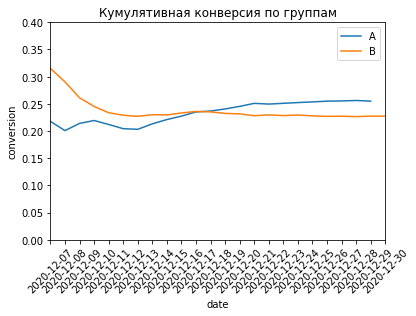

In [63]:
plt.plot(cumulative_data_A['event_dt'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['event_dt'], cumulative_data_B['conversion'], label='B')
plt.legend()
plt.xlabel('date')
plt.ylabel('conversion')
plt.title('Кумулятивная конверсия по группам')
plt.xticks(rotation=45)
plt.axis(["2020-12-07", '2020-12-30', 0, 0.4])
plt.show()

На графике кумулятивной конверсии по группам видно, что в начале эксперимента конверсия у группы В была выше, чем у группы А, но потом показатели групп поменялись, конверсия группы В стабильно ниже, чем у группы А 

#### Построим график относительного различия кумулятивных конверсий

In [64]:
#соединим таблицы cumulative_data_A и cumulative_data_B
cumulative_data_A_B = cumulative_data_A.merge(cumulative_data_B, left_on='event_dt'
                                              , right_on='event_dt', how='left', suffixes=['A', 'B']) 

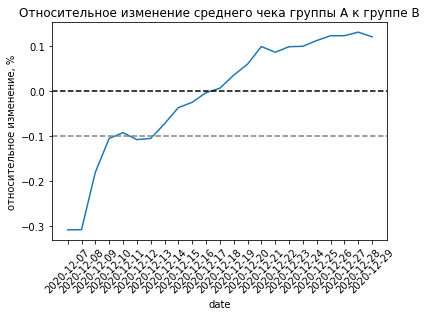

In [65]:
plt.plot(cumulative_data_A_B['event_dt'], cumulative_data_A_B['conversionA']/cumulative_data_A_B['conversionB']-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xlabel('date')
plt.ylabel('относительное изменение, %')
plt.title('Относительное изменение среднего чека группы A к группе B')
plt.xticks(rotation=45)
plt.show()

На графике относительного различия кумулятивных конверсий видно, что конверсия группы А во второй части эксперимента выше, чем группы В на 10% и более.

#### Проверим статистическую разницу долей z-критерием

In [66]:
#выделим воронку по группе А
funnel_A_array = funnel_A['user_nunique'].reset_index().values
funnel_A_array

array([[   0, 2588],
       [   1, 1673],
       [   2,  778],
       [   3,  775]])

In [67]:
#выделим воронку по группе B
funnel_B_array = funnel_B['user_nunique'].reset_index().values
funnel_B_array

array([[  0, 886],
       [  1, 504],
       [  2, 246],
       [  3, 240]])

Создадим df воронки по событию product_page для групп А и В

In [68]:
#создадим массив из количества пользователей по событиям login и product_page
successes = np.array([funnel_A_array[1], funnel_B_array[1]])
trials = np.array([funnel_A_array[0], funnel_B_array[0]])
trials_successes = np.concatenate([trials, successes], axis=1)
#преобразуем полученный массив в df
columns = ['index','trials', 'index', 'successes']
trials_successes = pd.DataFrame(data = trials_successes, columns = columns).drop(columns=['index'])
trials_successes

,trials,successes
0,2588,1673
1,886,504


Выберем критический уровень значимости alpha примем равной 0.5, а поскольку мы сравниваем 3 события, то пересчитаем alpha по методу Бонферрони

In [69]:
alpha = 0.5
bonferroni_alpha = alpha/3

Создадим функцию для расчета p_value

In [70]:
def pvalue(row):
    for i in range(len(row)):
        trials = row['trials']
        successes = row['successes']
        p1 = successes[0] / trials[0]
        p2 = successes[1] / trials[1]
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
        difference = p1 - p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

p_value = pvalue(trials_successes)
p_value

3.7640077360956425e-05

#### Проверяемые гипотезы равенства долей экспериментальных групп А/B теста:
- H0 - между долями есть значимая разница
- H1 - нет оснований считать доли разными

#### Проверим гипотезу о равенстве долей контрольных групп для события product_page

In [71]:
print('p-значение: ', p_value)

if (p_value < bonferroni_alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  3.7640077360956425e-05
Отвергаем нулевую гипотезу: между долями есть значимая разница


#### Проверим гипотезу о равенстве долей контрольных групп для события product_cart

In [72]:
#создадим массив из количества пользователей по событиям product_page и product_cart
successes = np.array([funnel_A_array[2], funnel_B_array[2]])
trials_successes = np.concatenate([trials, successes], axis=1)
#преобразуем полученный массив в df
columns = ['index','trials', 'index', 'successes']
trials_successes = pd.DataFrame(data = trials_successes, columns = columns).drop(columns=['index'])

In [73]:
p_value = pvalue(trials_successes)
print('p-значение: ', p_value)
if (p_value < bonferroni_alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  0.19563509360809261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Проверим гипотезу о равенстве долей контрольных групп для события purchase

In [74]:
#создадим массив из количества пользователей по событиям product_cart и purchase
successes = np.array([funnel_A_array[3], funnel_B_array[3]])
trials_successes = np.concatenate([trials, successes], axis=1)
#преобразуем полученный массив в df
columns = ['index','trials', 'index', 'successes']
trials_successes = pd.DataFrame(data = trials_successes, columns = columns).drop(columns=['index'])

In [75]:
p_value = pvalue(trials_successes)
print('p-значение: ', p_value)
if (p_value < bonferroni_alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  0.10641438955135363
Отвергаем нулевую гипотезу: между долями есть значимая разница


### Вывод

По результатам проведенного A/B теста сделать выводы:
- в начале эксперимента конверсия у группы В была выше, чем у группы А, но примерно на середине эксперимента (16.12) группа А стала показывать стабильно лучший результат по конверсии, чем у группы В, до конца эксперимента;
- по графику относительного различия кумулятивных конверсий видно, что конверсия группы А во второй части эксперимента выше, чем группы В примерно на 10% и более;
- проверка z-критерием равенства долей конверсий групп А и В по событию product_page показала, что между долями есть статистически значимая разница;
- проверка z-критерием равенства долей конверсий групп А и В по событию product_cart показала, что нет оснований считать доли разными;
- проверка z-критерием равенства долей конверсий групп А и В по событию purchase показала, что между долями есть статистически значимая разница.

### Шаг 5. Общие выводы.<a id="step5">

По результатам исследовательского анализа данных можно сделать выводы:
- Первоначально в логах количество событий покупка превышало количество событий просмотр корзины товаров, что логичестки неверно. Для очистки данных от выбросов проанализировали распределение событий по пользователям и исключили аномальных пользователей, а именно:
    - 5% пользователей, генерирующих событие login 6 и более раз;
    - 5% пользователей, генерирующих событие purchase 5 и более раз.

- По результатам анализа распределения стоиомости покупок удалили покупки стоимость которых выше 10 у.е.  
- Проверили, что в выборках по группам теста пользователи не дублируются.
- За период эксперимента 1 пользователь чаще всего совершает около 3 событий каждого типа, но не более 5 раз;
- За период эксперимента стоимость 1 покупки пользователя составиляла не более 10 у.е.;
- Наибольшее число событий пришлось на период середины эксперимента с 14-22 декабря 2020 года;
- Во время проведения теста с 25 декабря и с 30 декабря стартовали маркетинговые акции Christmas&New Year Promo и CIS New Year Gift Lottery, но как видно на графиках, они не повлияли на активность A/B теста, всплесков не обнаружено;
- События в тесте зафиксированы на 14 дней (по новым зарегистрированным пользователям) с 07 по 30 декабря 2020 года.

За весь период эксперимента конверсия по группам А и В:
1. login - 100%
2. product_page - А: 64,64%, В: 56,88%
3. product_cart - А: 30,06%, В: 27,77%
4. purchase - А: 29,95%, В: 27,09%
Конверсия группы В ниже, чем группы А.

По результатам проведенного A/B теста сделать выводы:
- в начале эксперимента конверсия у группы В была выше, чем у группы А, но примерно на середине эксперимента (16.12) группа А стала показывать стабильно лучший результат по конверсии, чем у группы В, до конца эксперимента;
- по графику относительного различия кумулятивных конверсий видно, что конверсия группы А во второй части эксперимента выше, чем группы В примерно на 10% и более;
- проверка z-критерием равенства долей конверсий групп А и В по событию product_page показала, что между долями есть статистически значимая разница;
- проверка z-критерием равенства долей конверсий групп А и В по событию product_cart показала, что нет оснований считать доли разными;
- проверка z-критерием равенства долей конверсий групп А и В по событию purchase показала, что между долями есть статистически значимая разница.

Результаты теста в соответствии с техническим заданием:
1. Планировалось: 15% новых пользователей из региона EU
   Получили: 94.72% новых пользователей из региона EU
2. Планировалось: 6000 новых пользователей
   Получили: 3675 новых пользователей
3. Планировалось: на каждом шаге воронки улучшение составит не менее 10%
   Получили: на каждом шаге воронки ухуджение 2%-8%.

#### Рекомендации:  
По результатам A/B теста можно сделать вывод о том, что новая рекомендательная система работает неэффективно, поскольку конверсия группы А выше, чем В, и разница между ними статистически значима. Рекомендуется не применять новую рекомендательную систему для пользователей международного интернет-магазина.